## DATA 620 - Project 2: Marvel Social Network Universe

**By Eddie Xu and Mohamed Hassan-El Serafi**

For this project:

Instructions:

Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
What can you infer about each of the distinct groups?
You may work in a small group on the project.

Your code and analysis should be delivered in an IPython Notebook by end of day Monday 

[Kaggle data link](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network)

In [1]:
# load packages
import pandas as pd
import numpy as np
import networkx as nx
import random
import movecolumn as mc
from scipy import stats
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,10)

# import packages to set up bipartite graph and communities
from networkx.algorithms import bipartite
from networkx.drawing.layout import bipartite_layout
from community import community_louvain
import networkx.algorithms.community as nx_comm
import matplotlib.cm as cm

### Data Selection

In [2]:
edges_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/edges.csv'
network_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/hero-network.csv'
nodes_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/nodes.csv' 

# extract data
nodes_raw = pd.read_csv(nodes_url)
edges_raw = pd.read_csv(edges_url)
network_raw = pd.read_csv(network_url)

### Exploratory Data Analysis

In [3]:
# Setting seed
random.seed(42)

#### Nodes

In [4]:
nodes_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19090 entries, 0 to 19089
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   node    19090 non-null  object
 1   type    19090 non-null  object
dtypes: object(2)
memory usage: 298.4+ KB


In [5]:
nodes_raw.head(10)

node   type
0               2001 10  comic
1                2001 8  comic
2                2001 9  comic
3  24-HOUR MAN/EMMANUEL   hero
4  3-D MAN/CHARLES CHAN   hero
5      4-D MAN/MERCURIO   hero
6               8-BALL/   hero
7                 A '00  comic
8                 A '01  comic
9                 A 100  comic

In [6]:
nodes_profile = ProfileReport(nodes_raw, title="Nodes Profiling Report")
nodes_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Edges

In [7]:
edges_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96104 entries, 0 to 96103
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hero    96104 non-null  object
 1   comic   96104 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [8]:
edges_raw.head(10)

hero     comic
0  24-HOUR MAN/EMMANUEL    AA2 35
1  3-D MAN/CHARLES CHAN     AVF 4
2  3-D MAN/CHARLES CHAN     AVF 5
3  3-D MAN/CHARLES CHAN     COC 1
4  3-D MAN/CHARLES CHAN    H2 251
5  3-D MAN/CHARLES CHAN    H2 252
6  3-D MAN/CHARLES CHAN  M/PRM 35
7  3-D MAN/CHARLES CHAN  M/PRM 36
8  3-D MAN/CHARLES CHAN  M/PRM 37
9  3-D MAN/CHARLES CHAN     WI? 9

In [9]:
edges_profile = ProfileReport(edges_raw, title="Edges Profiling Report")
edges_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Network

In [10]:
network_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574467 entries, 0 to 574466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   hero1   574467 non-null  object
 1   hero2   574467 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


In [11]:
network_raw.head(10)

hero1                 hero2
0         LITTLE, ABNER        PRINCESS ZANDA
1         LITTLE, ABNER  BLACK PANTHER/T'CHAL
2  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
3         LITTLE, ABNER        PRINCESS ZANDA
4         LITTLE, ABNER  BLACK PANTHER/T'CHAL
5  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
6  STEELE, SIMON/WOLFGA      FORTUNE, DOMINIC
7  STEELE, SIMON/WOLFGA   ERWIN, CLYTEMNESTRA
8  STEELE, SIMON/WOLFGA  IRON MAN/TONY STARK 
9  STEELE, SIMON/WOLFGA  IRON MAN IV/JAMES R.

In [12]:
network_profile = ProfileReport(network_raw, title="Network Profiling Report")
network_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Transformation

In [13]:
# For unipartite graph
# create the hero network
random.seed(42)
Thor_network = network_raw[network_raw['hero1'].str.contains('THOR/DR. DONALD BLAK')].sample(25)
Cap_network = network_raw[network_raw['hero1'].str.contains('CAPTAIN AMERICA')].sample(25)
IronMan_network = network_raw[network_raw['hero1'].str.contains('IRON MAN/TONY STARK')].sample(25)
BlackWidow_network = network_raw[network_raw['hero1'].str.contains('BLACK WIDOW/NATASHA')].sample(25)
Hulk_network = network_raw[network_raw['hero1'].str.contains('HULK/DR. ROBERT BRUC')].sample(25)

# combine all avenger networks into one
network_subset = pd.concat([Thor_network, Cap_network, IronMan_network, BlackWidow_network, Hulk_network],axis = 0)

In [14]:
## for bipartite graph
# create the avenger list
random.seed(42)
avenger_list = ['THOR/DR. DONALD BLAK', 'CAPTAIN AMERICA', 'IRON MAN/TONY STARK', 'BLACK WIDOW/NATASHA', 'HULK/DR. ROBERT BRUC']

# extract edges of original avengers except for hawkeyes as there is no data for it
Thor_edge = edges_raw[edges_raw['hero'].str.contains('THOR/DR. DONALD BLAK')].sample(25)
Cap_edge = edges_raw[edges_raw['hero'].str.contains('CAPTAIN AMERICA')].sample(25)
IronMan_edge = edges_raw[edges_raw['hero'].str.contains('IRON MAN/TONY STARK')].sample(25)
BlackWidow_edge = edges_raw[edges_raw['hero'].str.contains('BLACK WIDOW/NATASHA')].sample(25)
Hulk_edge = edges_raw[edges_raw['hero'].str.contains('HULK/DR. ROBERT BRUC')].sample(25)

# combine all avenger edges into one
edge_subset = pd.concat([Thor_edge, Cap_edge, IronMan_edge, BlackWidow_edge, Hulk_edge],axis = 0)
edge_list = list(zip(edge_subset['hero'], edge_subset['comic']))

# create the comic list
comic_list = edge_subset['comic']

### Network Analysis

#### Unipartite Network

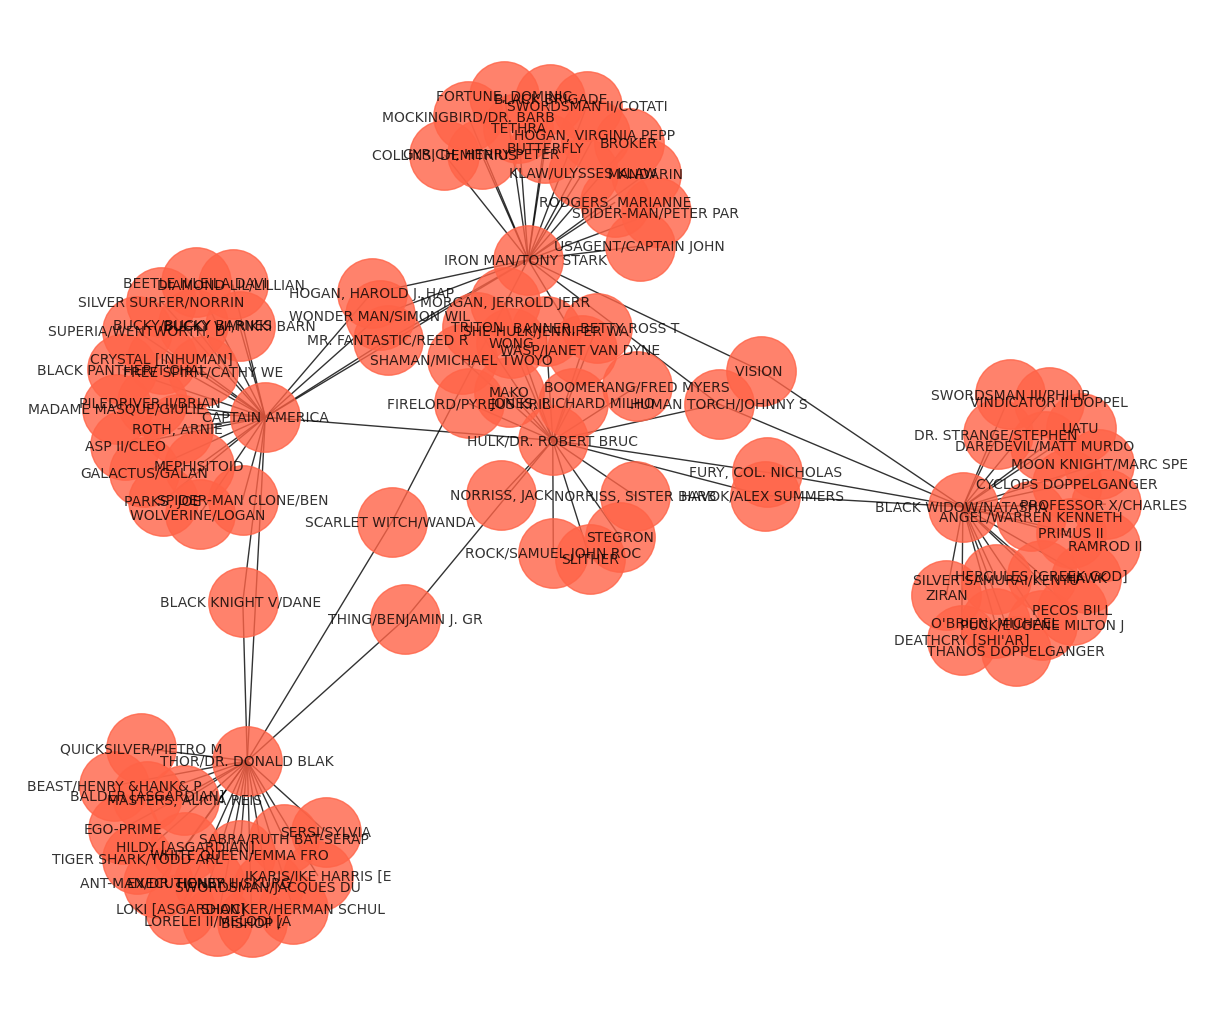

In [15]:
G=nx.from_pandas_edgelist(network_subset, 'hero1', 'hero2')
pos = nx.spring_layout(G, seed=648)  # Seed layout for reproducible node positions
nx.draw(G, pos, with_labels=True, node_size=2500, node_color="tomato", font_size=10, font_color="black", edge_color="black", alpha=0.8)

plt.show()

## Network Centrality

### Degree Centrality

In [16]:
# get the degree centrality
random.seed(42)
avenger_centrality = nx.degree_centrality(G)
sorted_avenger_centrality = sorted(avenger_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Degree Centrality:", sorted_avenger_centrality)
sorted_avenger_centrality

Top Avenger by Degree Centrality: [('CAPTAIN AMERICA', 0.24752475247524752), ('BLACK WIDOW/NATASHA ', 0.2376237623762376), ('IRON MAN/TONY STARK ', 0.22772277227722773), ('THOR/DR. DONALD BLAK', 0.21782178217821782), ('HULK/DR. ROBERT BRUC', 0.2079207920792079), ('HUMAN TORCH/JOHNNY S', 0.0297029702970297), ('BLACK KNIGHT V/DANE ', 0.019801980198019802), ('SCARLET WITCH/WANDA ', 0.019801980198019802), ('THING/BENJAMIN J. GR', 0.019801980198019802), ('WONDER MAN/SIMON WIL', 0.019801980198019802)]


[('CAPTAIN AMERICA', 0.24752475247524752),
 ('BLACK WIDOW/NATASHA ', 0.2376237623762376),
 ('IRON MAN/TONY STARK ', 0.22772277227722773),
 ('THOR/DR. DONALD BLAK', 0.21782178217821782),
 ('HULK/DR. ROBERT BRUC', 0.2079207920792079),
 ('HUMAN TORCH/JOHNNY S', 0.0297029702970297),
 ('BLACK KNIGHT V/DANE ', 0.019801980198019802),
 ('SCARLET WITCH/WANDA ', 0.019801980198019802),
 ('THING/BENJAMIN J. GR', 0.019801980198019802),
 ('WONDER MAN/SIMON WIL', 0.019801980198019802)]

In [17]:
avenger_degree_df = pd.DataFrame(sorted(avenger_centrality.items(), key=lambda x: x[1], reverse=True), 
                               columns=['Name', 'Degree Centrality'])

In [18]:
# top 10
avenger_degree_df.head(10)

Name  Degree Centrality
0       CAPTAIN AMERICA           0.247525
1  BLACK WIDOW/NATASHA            0.237624
2  IRON MAN/TONY STARK            0.227723
3  THOR/DR. DONALD BLAK           0.217822
4  HULK/DR. ROBERT BRUC           0.207921
5  HUMAN TORCH/JOHNNY S           0.029703
6  BLACK KNIGHT V/DANE            0.019802
7  SCARLET WITCH/WANDA            0.019802
8  THING/BENJAMIN J. GR           0.019802
9  WONDER MAN/SIMON WIL           0.019802

In [19]:
# bottom 10
avenger_degree_df.tail(10)

Name  Degree Centrality
92   NORRISS, SISTER BARB           0.009901
93   ROCK/SAMUEL JOHN ROC           0.009901
94          NORRISS, JACK           0.009901
95                   WONG           0.009901
96                STEGRON           0.009901
97   BOOMERANG/FRED MYERS           0.009901
98   MORGAN, JERROLD JERR           0.009901
99   SHAMAN/MICHAEL TWOYO           0.009901
100               SLITHER           0.009901
101                  MAKO           0.009901

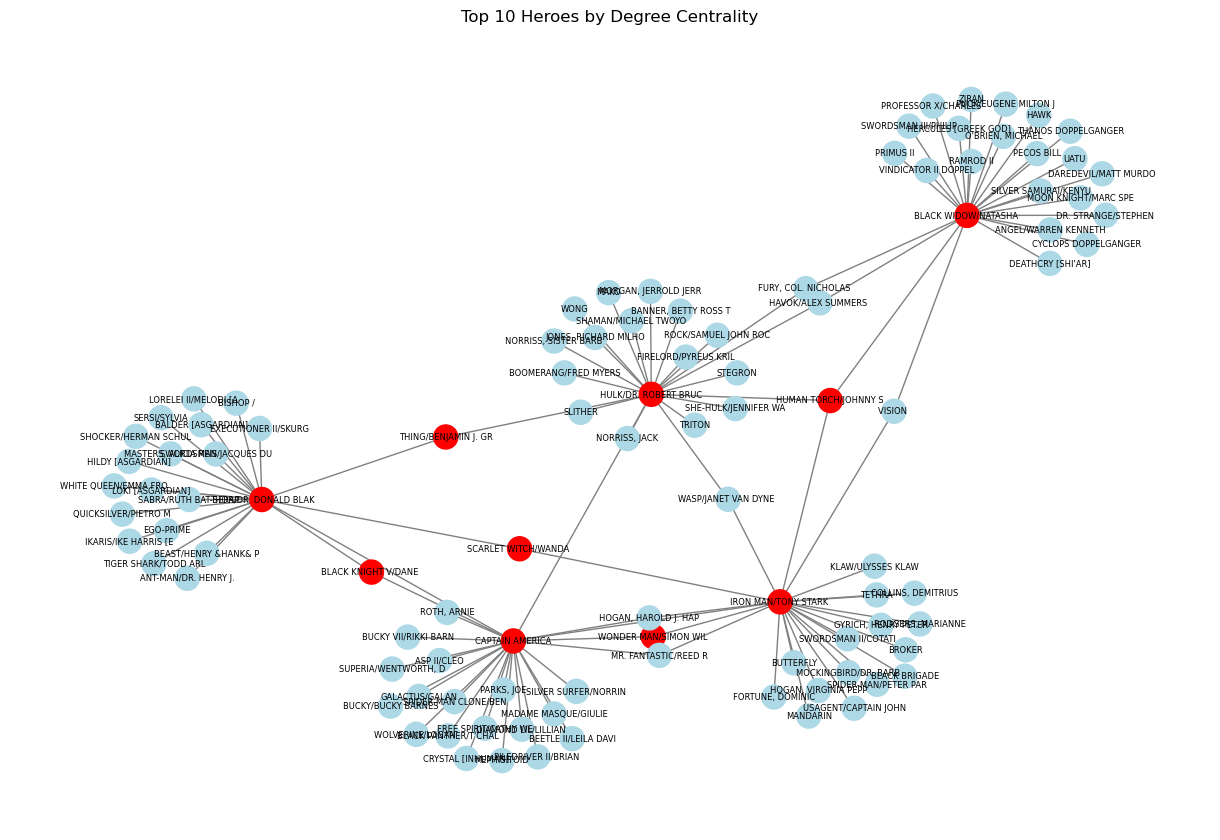

In [20]:
# Extract the top 10 nodes by degree centrality from the sampled graph
top_nodes1 = [node for node, _ in sorted_avenger_centrality]

# Assign colors: Highlight top nodes in red, others in blue
node_colors = ["red" if node in top_nodes1 else "lightblue" for node in G.nodes()]

# Plot the network with highlighted top nodes
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
        node_size=300, font_size=6, font_color="black")

plt.title("Top 10 Heroes by Degree Centrality")
plt.show()

### Betweenness Centrality

In [21]:
# get the betweeness centrality
random.seed(42)
avenger_betweeness_centrality = nx.betweenness_centrality(G)
sorted_betweeness_centrality = sorted(avenger_betweeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Betweeness Centrality:", sorted_betweeness_centrality)
sorted_betweeness_centrality

Top Avenger by Betweeness Centrality: [('CAPTAIN AMERICA', 0.4915884016973118), ('HULK/DR. ROBERT BRUC', 0.41445120226308335), ('IRON MAN/TONY STARK ', 0.38428783592644966), ('BLACK WIDOW/NATASHA ', 0.36351414427157), ('THOR/DR. DONALD BLAK', 0.3334893917963228), ('HUMAN TORCH/JOHNNY S', 0.15360160301744447), ('VISION ', 0.07617538896746814), ('THING/BENJAMIN J. GR', 0.060135785007072166), ('FURY, COL. NICHOLAS ', 0.05738448844884488), ('HAVOK/ALEX SUMMERS ', 0.05738448844884488)]


[('CAPTAIN AMERICA', 0.4915884016973118),
 ('HULK/DR. ROBERT BRUC', 0.41445120226308335),
 ('IRON MAN/TONY STARK ', 0.38428783592644966),
 ('BLACK WIDOW/NATASHA ', 0.36351414427157),
 ('THOR/DR. DONALD BLAK', 0.3334893917963228),
 ('HUMAN TORCH/JOHNNY S', 0.15360160301744447),
 ('VISION ', 0.07617538896746814),
 ('THING/BENJAMIN J. GR', 0.060135785007072166),
 ('FURY, COL. NICHOLAS ', 0.05738448844884488),
 ('HAVOK/ALEX SUMMERS ', 0.05738448844884488)]

In [22]:
avenger_betweenness_df = pd.DataFrame(sorted(avenger_betweeness_centrality.items(), key=lambda x: x[1], reverse=True), 
                               columns=['Name', 'Betweenness Centrality'])

In [23]:
# top 10
avenger_betweenness_df.head(10)

Name  Betweenness Centrality
0       CAPTAIN AMERICA                0.491588
1  HULK/DR. ROBERT BRUC                0.414451
2  IRON MAN/TONY STARK                 0.384288
3  BLACK WIDOW/NATASHA                 0.363514
4  THOR/DR. DONALD BLAK                0.333489
5  HUMAN TORCH/JOHNNY S                0.153602
6               VISION                 0.076175
7  THING/BENJAMIN J. GR                0.060136
8  FURY, COL. NICHOLAS                 0.057384
9   HAVOK/ALEX SUMMERS                 0.057384

In [24]:
# Bottom 10
avenger_betweenness_df.tail(10)

Name  Betweenness Centrality
92   NORRISS, SISTER BARB                     0.0
93   ROCK/SAMUEL JOHN ROC                     0.0
94          NORRISS, JACK                     0.0
95                   WONG                     0.0
96                STEGRON                     0.0
97   BOOMERANG/FRED MYERS                     0.0
98   MORGAN, JERROLD JERR                     0.0
99   SHAMAN/MICHAEL TWOYO                     0.0
100               SLITHER                     0.0
101                  MAKO                     0.0

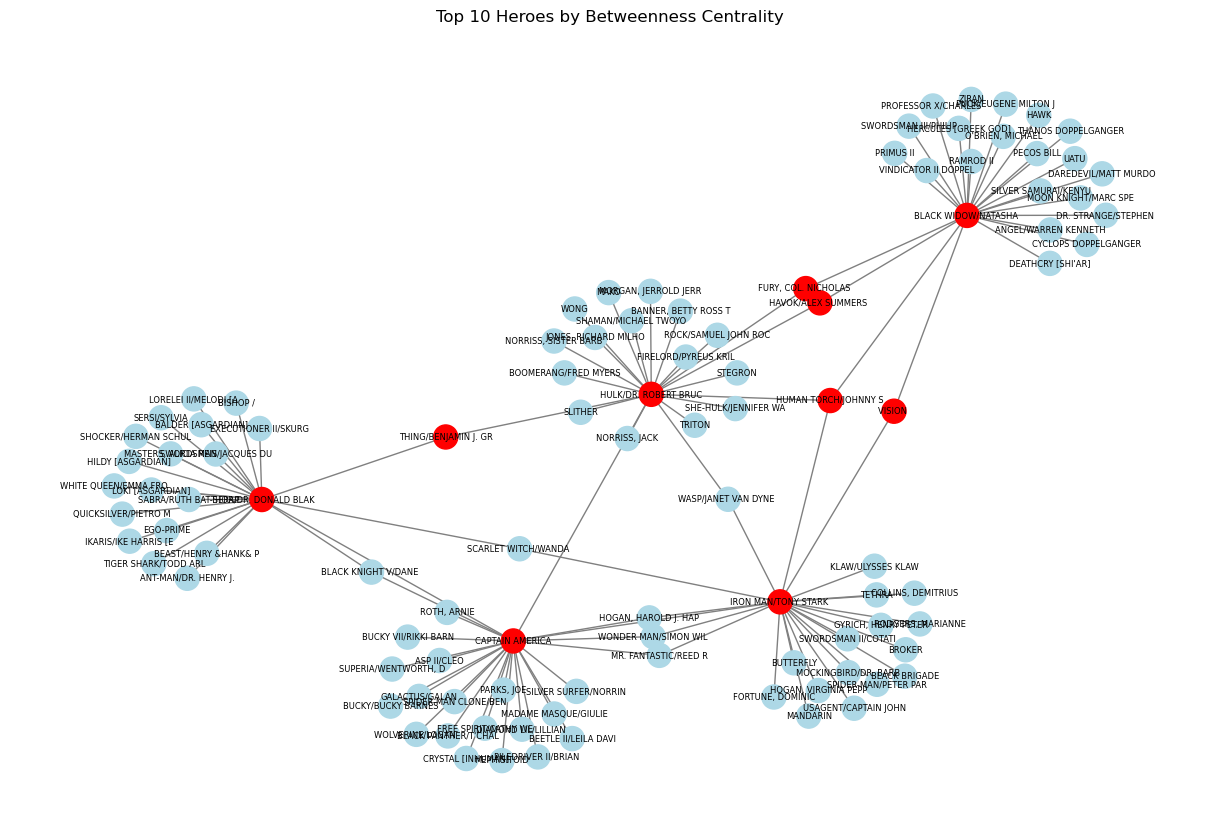

In [25]:
# Extract the top 10 nodes by degree centrality from the sampled graph
top_nodes2 = [node for node, _ in sorted_betweeness_centrality]

# Assign colors: Highlight top nodes in red, others in blue
node_colors = ["red" if node in top_nodes2 else "lightblue" for node in G.nodes()]

# Plot the network with highlighted top nodes
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
        node_size=300, font_size=6, font_color="black")

plt.title("Top 10 Heroes by Betweenness Centrality")
plt.show()

### Closeness Centrality

In [26]:
# get the closenss centrality
random.seed(42)
avenger_closeness_centrality = nx.closeness_centrality(G)
sorted_closeness_centrality = sorted(avenger_closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Closeness Centrality:", sorted_closeness_centrality)
sorted_closeness_centrality

Top Avenger by Closeness Centrality: [('CAPTAIN AMERICA', 0.463302752293578), ('IRON MAN/TONY STARK ', 0.4297872340425532), ('HULK/DR. ROBERT BRUC', 0.4279661016949153), ('HUMAN TORCH/JOHNNY S', 0.396078431372549), ('THOR/DR. DONALD BLAK', 0.36462093862815886), ('WONDER MAN/SIMON WIL', 0.36462093862815886), ('MR. FANTASTIC/REED R', 0.36462093862815886), ('HOGAN, HAROLD J. HAP', 0.36462093862815886), ('VISION ', 0.3494809688581315), ('FURY, COL. NICHOLAS ', 0.3458904109589041)]


[('CAPTAIN AMERICA', 0.463302752293578),
 ('IRON MAN/TONY STARK ', 0.4297872340425532),
 ('HULK/DR. ROBERT BRUC', 0.4279661016949153),
 ('HUMAN TORCH/JOHNNY S', 0.396078431372549),
 ('THOR/DR. DONALD BLAK', 0.36462093862815886),
 ('WONDER MAN/SIMON WIL', 0.36462093862815886),
 ('MR. FANTASTIC/REED R', 0.36462093862815886),
 ('HOGAN, HAROLD J. HAP', 0.36462093862815886),
 ('VISION ', 0.3494809688581315),
 ('FURY, COL. NICHOLAS ', 0.3458904109589041)]

In [27]:
avenger_closeness_df = pd.DataFrame(sorted(avenger_closeness_centrality.items(), key=lambda x: x[1], reverse=True), 
                               columns=['Name', 'Closeness Centrality'])

In [28]:
# top 10
avenger_closeness_df.head(10)

Name  Closeness Centrality
0       CAPTAIN AMERICA              0.463303
1  IRON MAN/TONY STARK               0.429787
2  HULK/DR. ROBERT BRUC              0.427966
3  HUMAN TORCH/JOHNNY S              0.396078
4  THOR/DR. DONALD BLAK              0.364621
5  WONDER MAN/SIMON WIL              0.364621
6  MR. FANTASTIC/REED R              0.364621
7  HOGAN, HAROLD J. HAP              0.364621
8               VISION               0.349481
9  FURY, COL. NICHOLAS               0.345890

In [29]:
# Bottom 10
avenger_closeness_df.tail(10)

Name  Closeness Centrality
92   MOON KNIGHT/MARC SPE              0.246944
93   SWORDSMAN III/PHILIP              0.246944
94   DAREDEVIL/MATT MURDO              0.246944
95   PUCK/EUGENE MILTON J              0.246944
96   SILVER SAMURAI/KENYU              0.246944
97             PECOS BILL              0.246944
98       O'BRIEN, MICHAEL              0.246944
99              RAMROD II              0.246944
100                 ZIRAN              0.246944
101  CYCLOPS DOPPELGANGER              0.246944

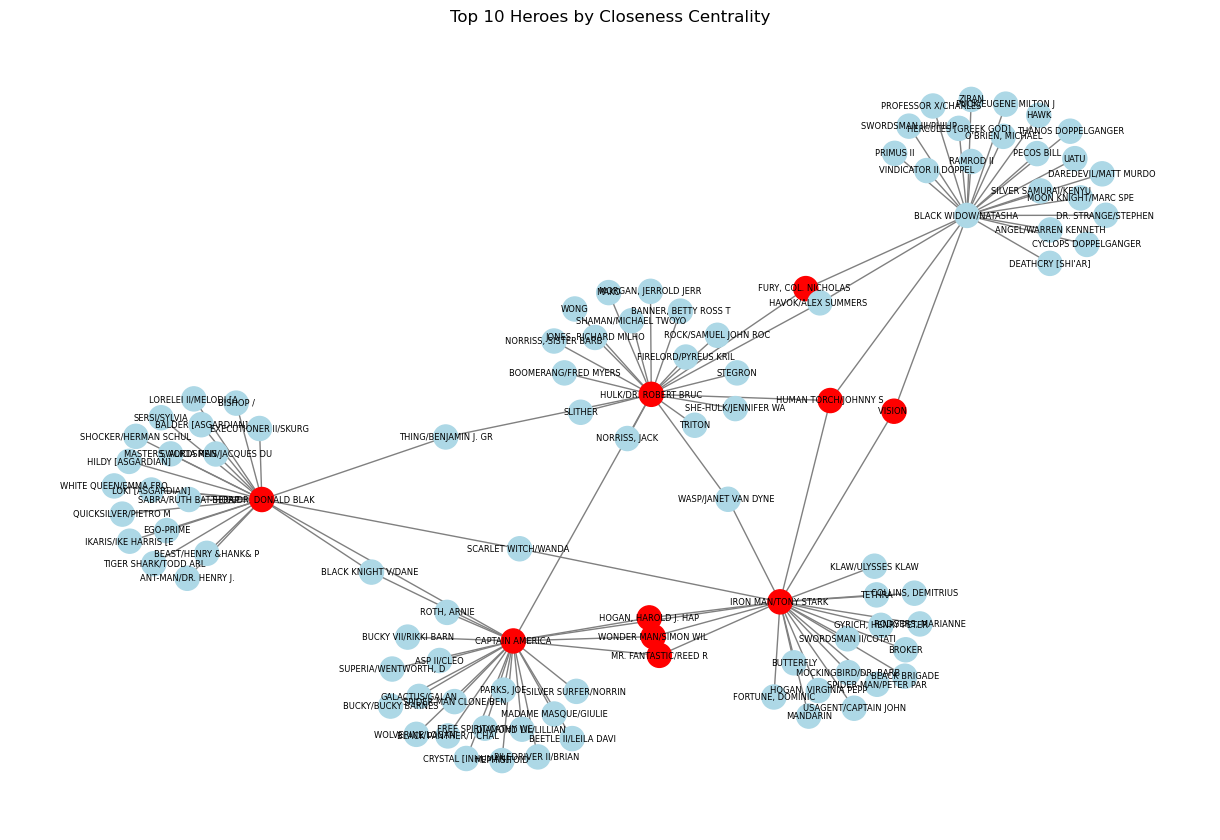

In [30]:
# Extract the top 10 nodes by degree centrality from the sampled graph
top_nodes3 = [node for node, _ in sorted_closeness_centrality]

# Assign colors: Highlight top nodes in red, others in blue
node_colors = ["red" if node in top_nodes3 else "lightblue" for node in G.nodes()]

# Plot the network with highlighted top nodes
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
        node_size=300, font_size=6, font_color="black")

plt.title("Top 10 Heroes by Closeness Centrality")
plt.show()

### Eigenvector Centrality

In [31]:
random.seed(42)
avenger_eigenvector_centrality = nx.eigenvector_centrality(G)
sorted_eigenvector_centrality = sorted(avenger_eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Eigenvector Centrality:", sorted_eigenvector_centrality)
sorted_eigenvector_centrality

Top Avenger by Eigenvector Centrality: [('CAPTAIN AMERICA', 0.5029739339392008), ('IRON MAN/TONY STARK ', 0.3952459745105654), ('HULK/DR. ROBERT BRUC', 0.2764792533640847), ('THOR/DR. DONALD BLAK', 0.27566895618881804), ('WONDER MAN/SIMON WIL', 0.14919569323849682), ('MR. FANTASTIC/REED R', 0.14919569323849682), ('HOGAN, HAROLD J. HAP', 0.14919569323849682), ('HUMAN TORCH/JOHNNY S', 0.13355887331505992), ('BLACK WIDOW/NATASHA ', 0.13233861377567088), ('BLACK KNIGHT V/DANE ', 0.12933311232815056)]


[('CAPTAIN AMERICA', 0.5029739339392008),
 ('IRON MAN/TONY STARK ', 0.3952459745105654),
 ('HULK/DR. ROBERT BRUC', 0.2764792533640847),
 ('THOR/DR. DONALD BLAK', 0.27566895618881804),
 ('WONDER MAN/SIMON WIL', 0.14919569323849682),
 ('MR. FANTASTIC/REED R', 0.14919569323849682),
 ('HOGAN, HAROLD J. HAP', 0.14919569323849682),
 ('HUMAN TORCH/JOHNNY S', 0.13355887331505992),
 ('BLACK WIDOW/NATASHA ', 0.13233861377567088),
 ('BLACK KNIGHT V/DANE ', 0.12933311232815056)]

In [32]:
avenger_eigenvector_df = pd.DataFrame(sorted(avenger_eigenvector_centrality.items(), key=lambda x: x[1], reverse=True), 
                               columns=['Name', 'Eigenvector Centrality'])

In [33]:
# top 10
avenger_eigenvector_df.head(10)

Name  Eigenvector Centrality
0       CAPTAIN AMERICA                0.502974
1  IRON MAN/TONY STARK                 0.395246
2  HULK/DR. ROBERT BRUC                0.276479
3  THOR/DR. DONALD BLAK                0.275669
4  WONDER MAN/SIMON WIL                0.149196
5  MR. FANTASTIC/REED R                0.149196
6  HOGAN, HAROLD J. HAP                0.149196
7  HUMAN TORCH/JOHNNY S                0.133559
8  BLACK WIDOW/NATASHA                 0.132339
9  BLACK KNIGHT V/DANE                 0.129333

In [34]:
# bottom 10
avenger_eigenvector_df.tail(10)

Name  Eigenvector Centrality
92   MOON KNIGHT/MARC SPE                0.021983
93   SWORDSMAN III/PHILIP                0.021983
94   DAREDEVIL/MATT MURDO                0.021983
95   PUCK/EUGENE MILTON J                0.021983
96   SILVER SAMURAI/KENYU                0.021983
97             PECOS BILL                0.021983
98       O'BRIEN, MICHAEL                0.021983
99              RAMROD II                0.021983
100                 ZIRAN                0.021983
101  CYCLOPS DOPPELGANGER                0.021983

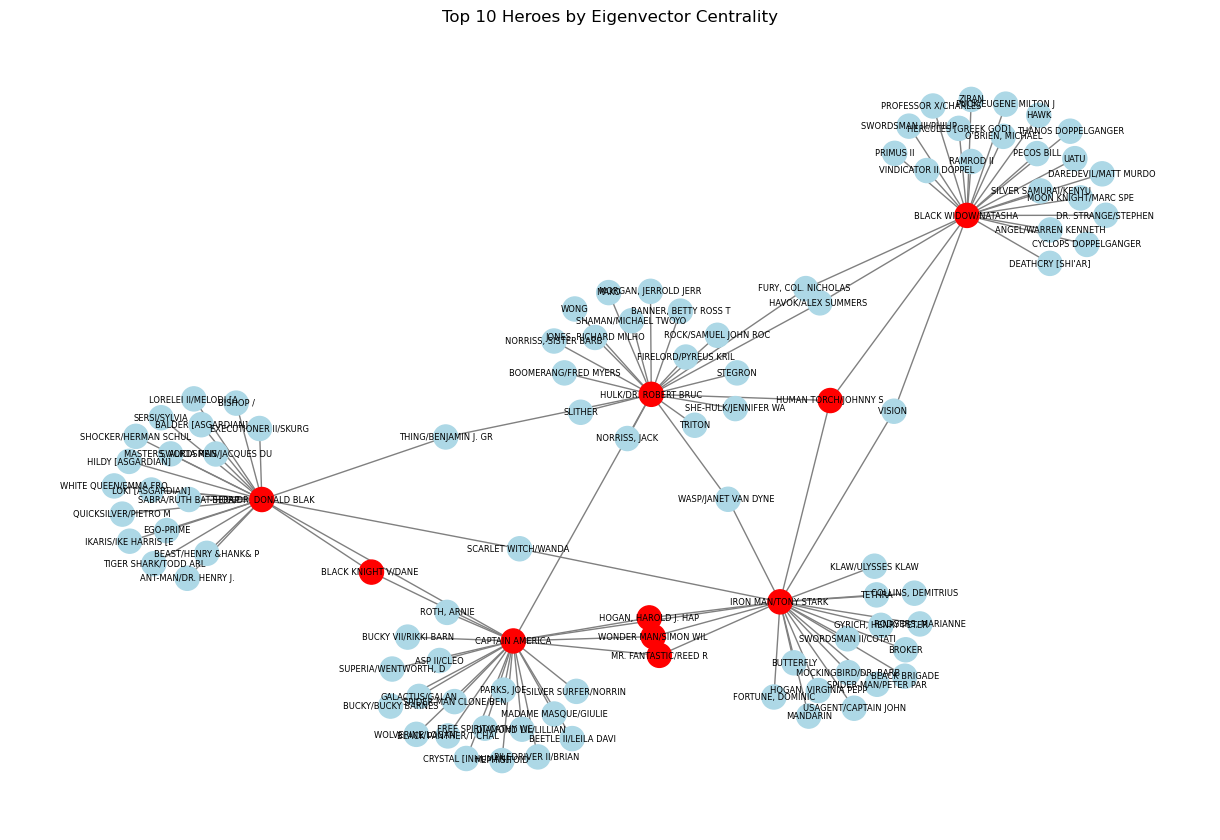

In [35]:
# Extract the top 10 nodes by degree centrality from the sampled graph
top_nodes4 = [node for node, _ in sorted_eigenvector_centrality]

# Assign colors: Highlight top nodes in red, others in blue
node_colors = ["red" if node in top_nodes4 else "lightblue" for node in G.nodes()]

# Plot the network with highlighted top nodes
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
        node_size=300, font_size=6, font_color="black")

plt.title("Top 10 Heroes by Eigenvector Centrality")
plt.show()

#### Bipartite Network

In [36]:
# create the bipartite graph
avenger_bipart = nx.Graph()

# add nodes and edges
avenger_bipart.add_nodes_from(comic_list, bipartite=0)
avenger_bipart.add_nodes_from(avenger_list, bipartite=1)
avenger_bipart.add_edges_from(edge_list)

# check if the graph is bipartite
print(bipartite.is_bipartite(avenger_bipart)) 

bipartite_none = list()
# Examine the bipartite attribute of each node
for node, data in avenger_bipart.nodes(data=True):
    if data.get('bipartite') == None:
        print(f"Node {node}: bipartite = {data.get('bipartite')}")
        bipartite_none.append(node)

True
Node CAPTAIN AMERICA IV/S: bipartite = None


In [37]:
# remove nodes that have NONE bipartite
avenger_bipart.remove_nodes_from(bipartite_none)

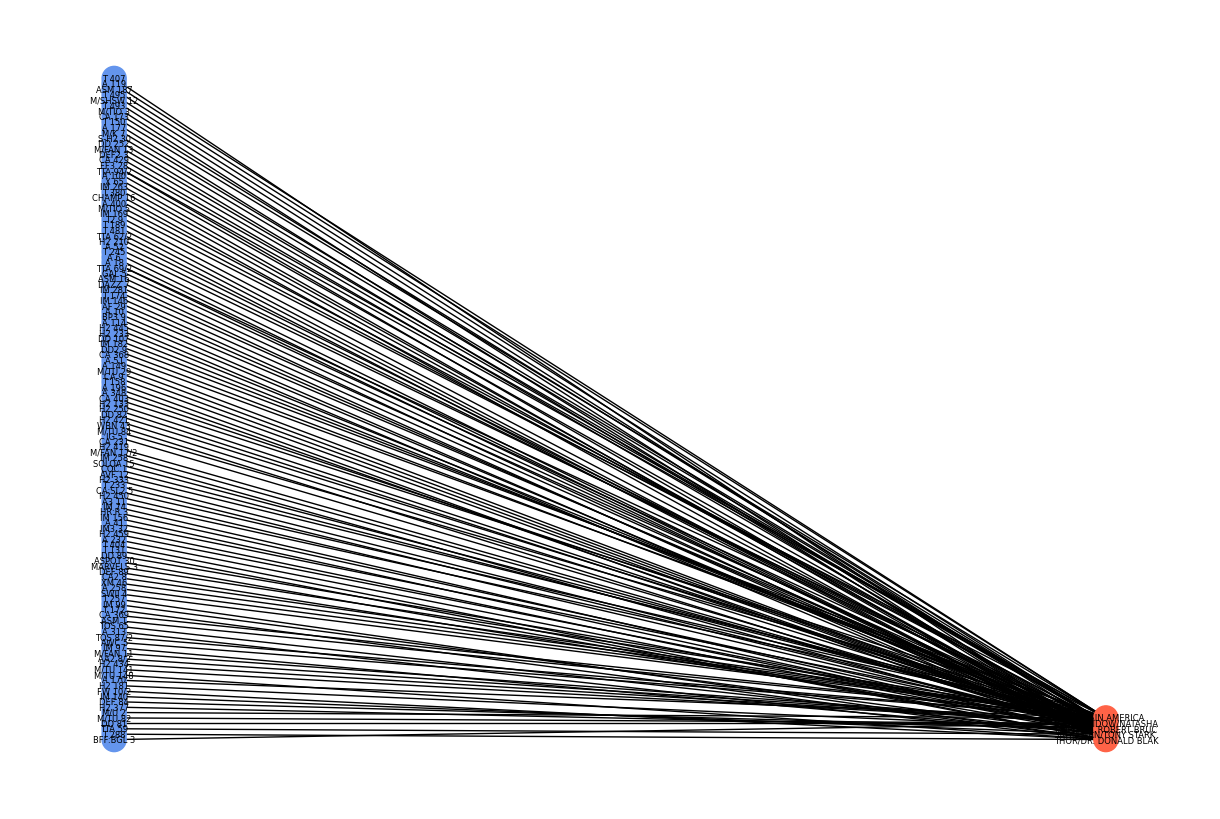

In [38]:
# separate nodes
top_nodes_subset = {n for n, d in avenger_bipart.nodes(data=True) if d['bipartite'] == 0}
bottom_nodes_subset = set(avenger_bipart) - top_nodes_subset
avenger_bipart.nodes(data=True)

# set node colors
color_dict = {0:'cornflowerblue', 1:'tomato'}
color_list = [color_dict[i[1]] for i in avenger_bipart.nodes.data('bipartite')]

# draw a bipartite graph
pos = dict()
color = []
plt.figure(figsize=(12, 8))

pos.update((n, (1, i)) for i, n in enumerate(top_nodes_subset)) 
pos.update((n, (2, i)) for i, n in enumerate(bottom_nodes_subset)) 
nx.draw(avenger_bipart, pos=pos, with_labels=True, node_color=color_list, font_size=6)
plt.show()

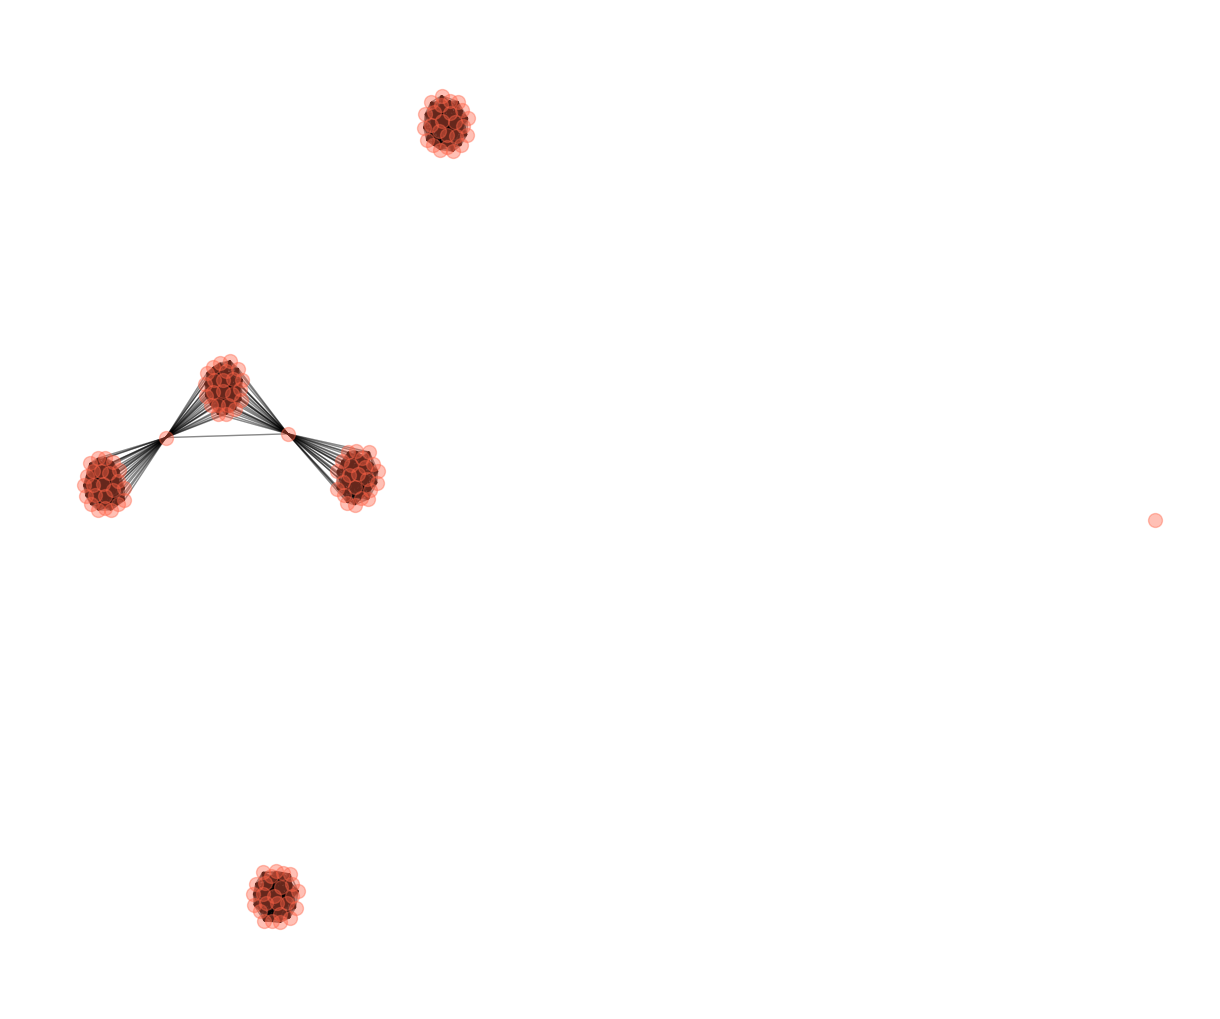

<Figure size 1200x800 with 0 Axes>

In [61]:
avenger_graph = bipartite.projected_graph(avenger_bipart, comic_list, multigraph=False)
# avenger_list
pos=nx.spring_layout(avenger_graph)
nx.draw(avenger_graph, pos=pos, node_size=100, node_color='tomato', alpha=0.4)
nx.draw_networkx_edges(avenger_graph, pos=pos, alpha=0.1)

plt.figure(figsize=(12, 8))
plt.show();

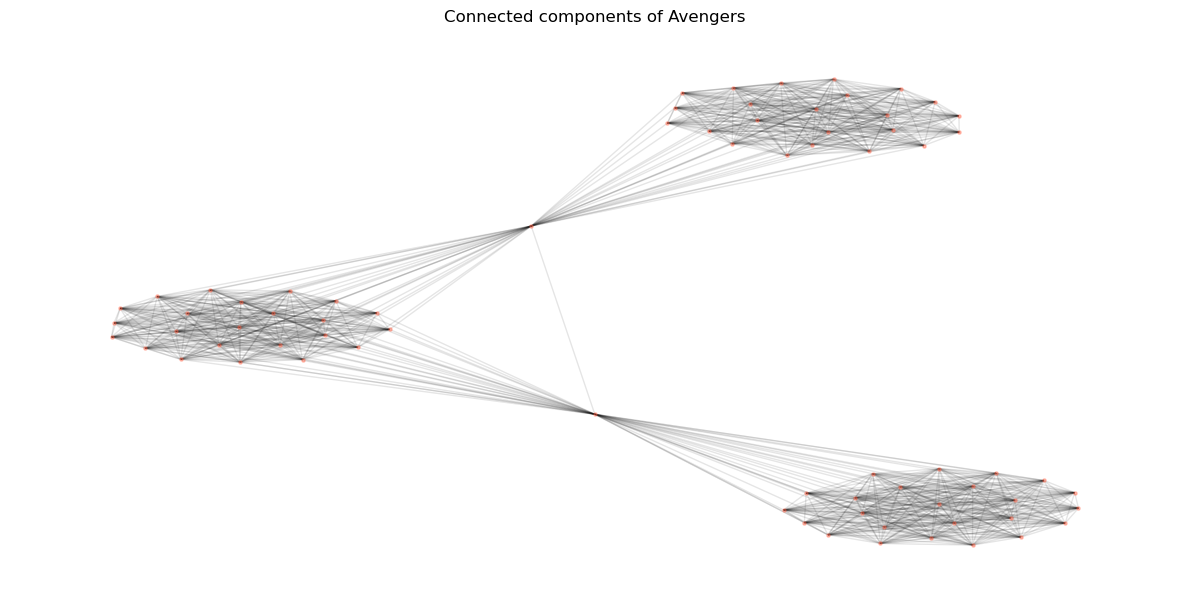

In [58]:
# Ranking of nodes regarding the number of degrees
degree_sequence = sorted([d for n, d in avenger_graph.degree()], reverse=True)

# Extract connected nodes to visualize
Gcc = avenger_graph.subgraph(sorted(nx.connected_components(avenger_graph), key=len, reverse=True)[0])

# Visualization
fig = plt.figure("Degree of the avenger graph")
axgrid = fig.add_gridspec(5, 4)
ax0 = fig.add_subplot(axgrid[0:3, :])
pos = nx.spring_layout(Gcc, seed=42)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=5, alpha=0.4, node_color='tomato')
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.1)
ax0.set_title("Connected components of Avengers")
ax0.set_axis_off()

fig.tight_layout()
plt.show()

/var/folders/6m/d853x4qs7139b3m7ydxp7jfm0000gn/T/ipykernel_36534/1667474521.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar', max(partition_avenger.values()) + 1)


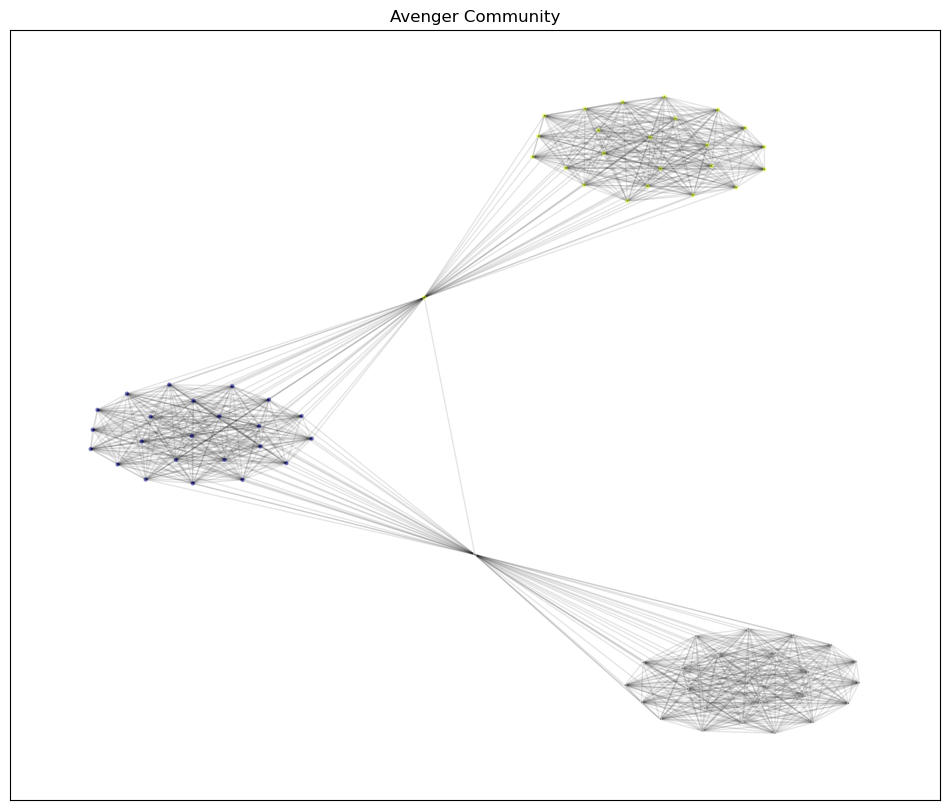

In [59]:
# Community division
partition_avenger = community_louvain.best_partition(Gcc)

# Color the nodes according to community
cmap = cm.get_cmap('gist_ncar', max(partition_avenger.values()) + 1)

pos = nx.spring_layout(Gcc, seed=42)
nx.draw_networkx_nodes(Gcc, pos, partition_avenger.keys(), node_size=5, alpha=0.4,
                       cmap=cmap, node_color=list(partition_avenger.values()))
nx.draw_networkx_edges(Gcc, pos, alpha=0.1)
plt.title("Avenger Community")
plt.show()

In [60]:
# find the modularity
avenger_modularity = nx_comm.modularity(avenger_graph, nx_comm.label_propagation_communities(avenger_graph))


print(f'Modularity of Hero network: {avenger_modularity}')

Modularity of Hero network: 0.6980410598482678


## Key Insights & Observations

When analyzing the top 10 heroes among each centrality measure, a few noteworthy observations stick out. Captain America ranks first in degree, betweenness, closeness and eigenvector centralities. His rankings indicates that he plays a prominent role in the amount of connections he has, how well-connected he is to other heroes that are also well-connected, and is a bridge between and close to other characters. He's essentially at the center of the Marvel universe. Additionally, Iron Man is ranked no lower than 3rd in each of the centrality measures, which demonstrates his strong presence in the Marvel universe. This isn't totally surprising, since Captain America and Iron Man are popular comic book heroes and are often working together. While The Hulk ranked second in degree and betweenness centralities, he ranked 6th in closeness and eigenvector centralities, which is understandable considering that while he is strong he also has uncontrollable rage, which might affect how other heroes interact with him. 
Heroes that have the lowest centrality measures are not well known. North Star ranked last in each centrality measure, which indicates that he wasn't popular among marvel comicbook heroes. An interesting fact about North Star is that he was the first openly gay Marvel comic hero created. 

For the bipartite analysis, it shows that original avengers appear to multiple comics multiple times. After put them in communities, there are few clusters where avengers are densely connected in nodes which makes senses they act as one superhero team. For modularity, a measure to determine how good the cluster is, the avenger community have a positive and relatively high score of 0.62683. 